This notebook needs to have the hovernet previously done on the WSIs and just use the results to analysis them.

In [64]:
import warnings
import scipy.io
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


Matching the tiles between 20X and 5X

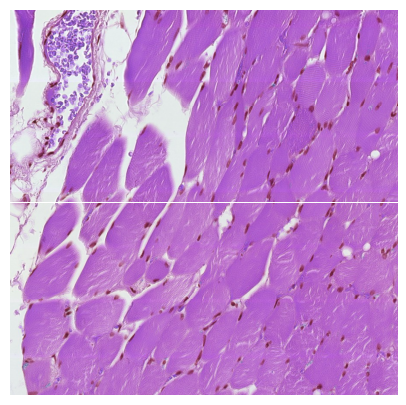

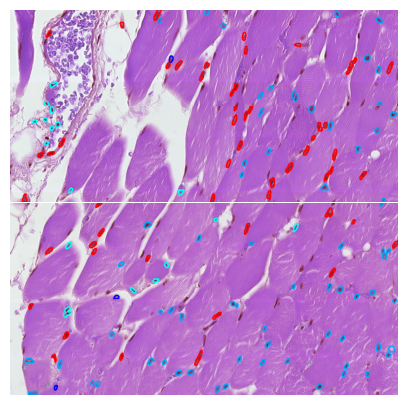

In [69]:
fig1, ax1 = plt.subplots(4,4, figsize=(5,5))
fig2, ax2 = plt.subplots(4,4, figsize=(5,5))

#  make the space between the plots to zero
fig1.subplots_adjust(hspace=0, wspace=0)
fig2.subplots_adjust(hspace=0, wspace=0)

# off the grids
for ax in ax1.flat:
    ax.axis('off')
for ax in ax2.flat:
    ax.axis('off')

i_5x, j_5x = 12, 20
start_i, start_j = i_5x*4, j_5x*4


for i in range(start_i, start_i+4):
    for j in range(start_j, start_j+4):
        try:
            folder, format_ = 'overlay', 'png'
            path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_229_6_files/20.0/overlay/{}_{}.png'.format(i,j)
            overlay = cv2.imread(path)

            # load the original image
            path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/MESO_229_6_files/20.0/{}_{}.jpeg'.format(i, j)
            image = cv2.imread(path)

            i_plot = i-start_i
            j_plot = j-start_j

            ax1[j_plot, i_plot].imshow(image)
            ax2[j_plot, i_plot].imshow(overlay)

        except:
            pass

plt.show()



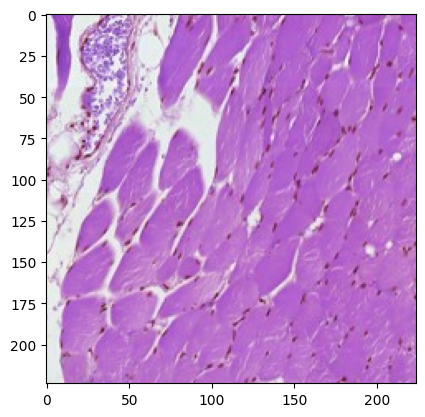

In [70]:
# show the 5x version of the image
path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/MESO_229_6_files/5.0/{}_{}.jpeg'.format(i_5x, j_5x)
image = cv2.imread(path)
plt.imshow(image)
plt.show()

In [32]:
# open json file
folder, format_ = 'json', 'json'
path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_229_6_files/20.0/{}/147_83.{}'.format(folder, format_)
json_file = open(path)
data = json.load(json_file)
data

dict_keys(['mag', 'nuc'])